# Final Project: 

In [47]:
import os
import numpy as np
import pandas as pd
import math
import matplotlib.patches as patches
import matplotlib.pylab as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn import preprocessing
from sklearn import cross_validation
from sklearn.cross_validation import train_test_split
from sklearn import tree
from sklearn import metrics
from sklearn import datasets
from IPython.display import Image
import seaborn as sb
from fuzzywuzzy import fuzz
import difflib
import re
import jellyfish
from datetime import datetime
from dateutil.relativedelta import relativedelta
%matplotlib inline

The goal is to predict the operating condition of a waterpoint for each record in the dataset. We are provided the following set of information about the waterpoints:

* amount_tsh - Total static head (amount water available to waterpoint)
* ~~date_recorded - The date the row was entered~~
* funder - Who funded the well
* gps_height - Altitude of the well
* installer - Organization that installed the well
* longitude - GPS coordinate
* latitude - GPS coordinate
* ~~wpt_name - Name of the waterpoint if there is one~~
* ~~num_private~~ wtf is this?
* basin - Geographic water basin
* subvillage - Geographic location
* region - Geographic location
* region_code - Geographic location (coded)
* district_code - Geographic location (coded)
* lga - Geographic location
* ward - Geographic location
* population - Population around the well
* public_meeting - True/False
* ~~recorded_by - Group entering this row of data~~
* scheme_management - Who operates the waterpoint
* scheme_name - Who operates the waterpoint
* permit - If the waterpoint is permitted
* construction_year - Year the waterpoint was constructed
* extraction_type - The kind of extraction the waterpoint uses
* extraction_type_group - The kind of extraction the waterpoint uses
* extraction_type_class - The kind of extraction the waterpoint uses
* management - How the waterpoint is managed
* management_group - How the waterpoint is managed
* payment - What the water costs
* payment_type - What the water costs
* water_quality - The quality of the water
* quality_group - The quality of the water
* quantity - The quantity of water
* quantity_group - The quantity of water
* source - The source of the water
* source_type - The source of the water
* source_class - The source of the water
* waterpoint_type - The kind of waterpoint
* waterpoint_type_group - The kind of waterpoint

In [48]:
# Since we are dealing with a lot of columns, let's force pandas to display all of them
pd.set_option('display.max_columns', None)

In [85]:
trainValues = pd.read_csv('train_values.csv', parse_dates = True)
trainLabels = pd.read_csv('train_labels.csv')

In [86]:
# Merge along id
train = pd.merge(trainValues, trainLabels, on='id')

## Data Exploration

* First count missing values to see which attributes to focus on. Only NaNs and zeros are considered missing, this has not taken into consideration _Other_, _Unknown_, ect

In [87]:
def countMissing(df):
    zeros = df[df == 0].count()
    nan = df.isnull().sum()
    total = zeros + nan
    prop = total/len(df) * 100
    summary = pd.concat([zeros, nan, total, prop], axis = 1)
    summary.columns = ['Zero', 'NaN', 'Total', 'Percentage of Data']
    return summary
    
countMissing(train)

,Zero,NaN,Total,Percentage of Data
id,1,0,1,0.001684
amount_tsh,41639,0,41639,70.099327
date_recorded,0,0,0,0.000000
funder,0,3635,3635,6.119529
gps_height,20438,0,20438,34.407407
installer,0,3655,3655,6.153199
longitude,1812,0,1812,3.050505
latitude,0,0,0,0.000000
wpt_name,0,0,0,0.000000
num_private,58643,0,58643,98.725589


* Make cross table for each column against status to check for patterns

In [88]:
# Make cross table for each column against status to check for patterns
def crossTab(dataframe, refCol):
    colNames = list(dataframe.drop([refCol], 1))
    ctDict = {}
    for i in colNames:
        ctDict['crossTab_{}'.format(i)] = pd.crosstab(dataframe[i], dataframe[refCol])
    return ctDict

tables = crossTab(train, 'status_group')

In [95]:
tables['crossTab_quantity']

status_group,functional,functional needs repair,non functional
quantity,,,
dry,157,37,6052
enough,21648,2400,9138
insufficient,7916,1450,5763
seasonal,2325,416,1309
unknown,213,14,562


* crossTab_quantity: most 'dry's are non-functional
* crossTab_funder: need cleaning
* crossTab_installer: need cleaning
* crossTab_subvillage: need cleaning, might be fubar
* crossTab_region, region_code, district_code: clean. more region codes than both region and district codes, not sure why
* crossTab_scheme_name: need cleaning

## Data cleaning and manipulation

### Time variables

- Converts the date-related variables to datetime format
- Corrects a typo: some observations (9) seem like they would have been recorded 10 years before all the others
- Creates new variable called 'operation_time' which is the difference between the date recorded and the construction year, converts it to integer
- Creates variable for 'month' from 'date_recorded'

In [51]:
def timecleaner(df):
    
    df.construction_year=pd.to_numeric(df.construction_year)
    df.loc[df.construction_year <= 0, df.columns=='construction_year'] = 1950 #arbitrary decision for the missing values
    df.date_recorded = df.date_recorded.apply(pd.to_datetime)
    
    timestamp1 = "Jan 1 01:01:01 2005" #there are 9 observations recorded in 2004, it is probably a mistake since all the other observations are dated between 2011 and 2013
    #I'll recode them to 2014
    t1 = datetime.strptime(timestamp1, "%b %d %H:%M:%S %Y") #this is the timestamp for comparison
    
    df['date_recorded'] = df.date_recorded.apply(lambda x: x.replace(year = x.year + 10) if x < t1 else x)
    
    #create the variable operation_time (idea taken from mattiaf), which is construction year subtracted from date_recorded in days
    df['operation_time'] = df.date_recorded - df.construction_year.apply(lambda x: pd.to_datetime(x, format = '%Y'))
    df['operation_time'] = df.operation_time.apply(lambda x: (x / np.timedelta64(1, 'D')).astype(int))
    #df.loc[df['operation_time'] < 0, df.columns=='operation_time'] = 63.92060232717317

    df['month']=pd.to_datetime(df.date_recorded).dt.month #not sure whether we should keep this
    return df

### Cleaning and string matching for variables 'funder', 'installer', 'scheme_name'

- Checks for several possible notations of missing values, sets them to 'Other'

In [52]:
def cleaner(df, variable, varstring):
    checklist = ['0', 'None', 'Not Known', 'no scheme', 'Unknown', 'none']
    for i in checklist:
        df.loc[variable == i, df.columns == varstring] = 'Other'
        df.loc[variable != variable, df.columns == varstring] = 'Other'
    return df

- Normalizes the string given as imput (deletes whitespaces, converts to lowercase) for furher string matching

In [53]:
def process_str_for_similarity_cmp(input_str, normalized=False, ignore_list=[]):
    """ Processes string for similarity comparisons , cleans special characters and extra whitespaces
        if normalized is True and removes the substrings which are in ignore_list)
    Args:
        input_str (str) : input string to be processed
        normalized (bool) : if True , method removes special characters and extra whitespace from string,
                            and converts to lowercase
        ignore_list (list) : the substrings which need to be removed from the input string
    Returns:
       str : returns processed string
    """ #this piece of code is from http://stackoverflow.com/questions/38969383/fuzzy-string-matching-in-python
    for ignore_str in ignore_list:
        input_str = re.sub(r'{0}'.format(ignore_str), "", input_str, flags=re.IGNORECASE)

    if normalized is True:
        input_str = input_str.strip().lower()
        #clean special chars and extra whitespace
        input_str = re.sub("\W", "", input_str).strip()

    return input_str

- Creates groups for similar names (used for the variables 'funder', 'installer', 'scheme_name')
- Checks whether there are similar string to each unique value of the given variable
- Match ratio is computed as an average of the output of difflib's SequenceMatcher and jellyfish's Jaro-Winkler algorithm for each pair of strings
- Similarity defined as match ratio >= 0.8 (min: 0, max: 1)
- Returns a list of grouped unique names

In [54]:
def strmatcher(uniquenames): #this function creates groups from similar names (the threshold is 0.8 here)
    possiblelist = uniquenames
    matches = []
    for i in possiblelist:
        str_i = process_str_for_similarity_cmp(i) #string processing to normalize it (lowercase, no whitespaces and so on)
        imatches = [i]
        possiblelist.remove(i)
        for j in possiblelist:
            str_j = process_str_for_similarity_cmp(j)
            #match ratio is the average of the outputs of difflib's SequenceMatcher and Jellyfish's Jaro Winkler algorithm
            match_ratio = (difflib.SequenceMatcher(None, process_str_for_similarity_cmp(i), process_str_for_similarity_cmp(j)).ratio() + jellyfish.jaro_winkler(unicode(process_str_for_similarity_cmp(i)), unicode(process_str_for_similarity_cmp(j))))/2.0
            if match_ratio >= 0.8: 
                imatches.append(j) #imatches: similar groups for every item in possiblelist
                possiblelist.remove(j)
        matches.append(imatches)
    return matches

- If a value of the observed variable belongs to a group, we match the first item of the group to the observation in a new column in the original dataframe (the similar stringgroups are going to be handled this way)

In [55]:
#this function runs for a few minutes
def backtodf(df, varname, newvarname, group): #the function stores the grouped names in the newly created columns
    for index, row in df.iterrows():
        searchfor = df.loc[index][varname]
        for sublist in group:
            for item in sublist:
                if item == searchfor:
                    df.ix[index, newvarname] = sublist[0] #the first element of the sublist is going to be the name of the funder
    return df

- Check whether the certain name is 'small' i. e. has less than 10 occurrences -> sets it to 'Other'

In [56]:
def checknames(x, smallnames): #changes the names of the small funders or installers to 'Other'
    if x in smallnames:
        return 'Other'
    else:
        return x

* Impute population. Assign average population of selected attribute to missing population. If entire population of selected attribute is missing, assign average population of the entire dataset. 

In [57]:
def imputeAverage(target, base, df):
    df[target] = df[target].apply(lambda x: x if x >0 else pd.np.nan)
    m = df.groupby(base)[target].mean()
    m = m.apply(lambda x: x if x == x else m.mean())
    df[target] = df.apply(lambda row: m[row[base]]
                                 if pd.isnull(row[target])
                                 else row[target], axis = 1)

- Allcleaner calls all the above defined functions to clean the following variables: 'funder', 'installer', 'wpt_name' 'scheme_management', 'scheme_name'
- Searches for missing values denoted in different ways
- Performs fuzzy string matching
- Checks for values with few occurrences -> sets them to 'Other'

In [96]:
def allcleaner(df):
    df = timecleaner(df)
    
    df = cleaner(df, df.funder, 'funder')
    df = cleaner(df, df.installer, 'installer')
    df = cleaner(df, df.scheme_management, 'scheme_management')
    df = cleaner(df, df.scheme_name, 'scheme_name')
    df = cleaner(df, df.wpt_name, 'wpt_name')
    
    funderfuzzy = list(df.funder.unique())
    installerfuzzy = list(df.installer.unique())
    schemefuzzy = list(df.scheme_name.unique())
    
    fundergroups = strmatcher(funderfuzzy) #these are the groups which are going to be matched
    installergroups = strmatcher(installerfuzzy)
    schemegroups = strmatcher(schemefuzzy)
    
    #back to the df

    df['funder_group'] = 0 #create new column for the funder names
    df['installer_group'] = 0 #create new column for the installer names
    df['scheme_name_group'] = 0 #create new column for the scheme names
    
    df = backtodf(df, 'funder','funder_group', fundergroups)
    df = backtodf(df, 'installer','installer_group', installergroups)
    df = backtodf(df, 'scheme_name','scheme_name_group', schemegroups)
    
    df.funder_group[df.funder_group == 0] = df.funder #if no similar value, funder_group gets the same value as funder
    df.installer_group[df.installer_group == 0] = df.installer #same for installer
    df.scheme_name_group[df.scheme_name_group == 0] = df.scheme_name #same for scheme name
    
    funders = df.groupby('funder_group').count() #grouping by funder name
    smallfunders = funders[funders['id'] < 10]
    smallfunders = list(smallfunders.index.values) #list of funders with less than 10 occurrence

    installers = df.groupby('installer_group').count() #grouping by installer name
    smallinst = installers[installers['id'] < 10]
    smallinst = list(smallinst.index.values) #list of installers with less than 10 occurrence

    schemes = df.groupby('scheme_name_group').count() #grouping by scheme name
    smallscheme = schemes[schemes['id'] < 10]
    smallscheme = list(smallscheme.index.values) #list of scheme names with less than 10 occurrence
    
    df['funder_group'] = df['funder_group'].apply(checknames, args=(smallfunders,))
    df['installer_group'] = df['installer_group'].apply(checknames, args=(smallinst,))
    df['scheme_name_group'] = df['scheme_name_group'].apply(checknames, args=(smallscheme,))
    
    imputeAverage('population', 'region', df) # regional population average for missing population. if not available, average all population
    imputeAverage('longitude', 'region', df)
    return df

In [97]:
train = allcleaner(train)

/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Original unique occurrences of the variables:

In [60]:
for i in ['funder', 'installer', 'scheme_name']:
    print(len(train[i].unique()))

1894
2144
2694


After data cleaning and setting small groups to 'Other':

In [65]:
for i in ['funder_group', 'installer_group', 'scheme_name_group']:
    print(len(train[i].unique()))

346
364
595


## Modeling

Convert to factors
* Preserve attributes that are already numeric and convert the rest

In [98]:
numericAttr = ['id','latitude','longitude','gps_height','date_recorded','construction_year','month','operation_time', 'population']
factorConvert = [x for x in train.columns if x not in numericAttr]

for factor in factorConvert:
    train[factor] = preprocessing.LabelEncoder().fit_transform(train[factor])

Start tree
* Feature selection: exclude certain attributes which have either too messy data or contain too many missing values. Certain attributes which we consider to be useless (such as id, pump name, etc) are also excluded.

In [102]:
excludeAttr = ['date_recorded', 'wpt_name', 'num_private', 'subvillage', 'installer', 'funder', 'scheme_name',
              'recorded_by', 'status_group', 'id', 'construction_year']

In [103]:
Y = train['status_group']
X = train.drop(excludeAttr, axis = 1)

In [104]:
treeEntropy = DecisionTreeClassifier(max_depth = 12, criterion = 'entropy')
treeEntropy.fit(X, Y)
#Decision_Tree_Image(treeEntropy, X.columns)
print "Accuracy score for tree is %.3f" %metrics.accuracy_score(treeEntropy.predict(X), Y)

Accuracy score for tree is 0.797


Split set

In [105]:
Xtrain, Xtest, Ytrain, Ytest = train_test_split(X, Y, train_size = 0.80)

In [106]:
treeEntropy.fit(Xtrain, Ytrain)
print 'Accuracy score of tree on train = %.3f' %metrics.accuracy_score(treeEntropy.predict(Xtrain), Ytrain)
print 'Accuracy score of tree on test = %.3f' %metrics.accuracy_score(treeEntropy.predict(Xtest), Ytest) 

Accuracy score of tree on train = 0.792
Accuracy score of tree on test = 0.744


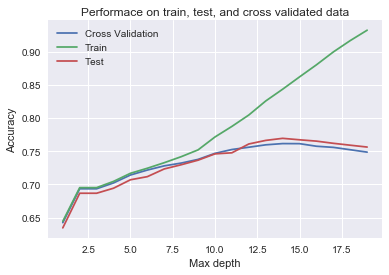

In [107]:
accuraciesTrain = []
accuraciesTest = []
accuraciesCrossValidation = []

depths = range(1, 20)

for md in depths:
    model = DecisionTreeClassifier(max_depth = md)
    model.fit(Xtrain, Ytrain)
    
    accuraciesTrain.append(metrics.accuracy_score(model.predict(Xtrain), Ytrain))
    accuraciesTest.append(metrics.accuracy_score(model.predict(Xtest), Ytest))
    accuraciesCrossValidation.append(np.mean(cross_validation.cross_val_score(model, X, Y)))

plt.plot(depths, accuraciesCrossValidation, label = "Cross Validation")
plt.plot(depths, accuraciesTrain, label = "Train")
plt.plot(depths, accuraciesTest, label = "Test")
plt.title("Performace on train, test, and cross validated data")
plt.xlabel("Max depth")
plt.ylabel("Accuracy")
#plt.ylim([0.8, 1.0])
#plt.xlim([1,20])
plt.legend()
plt.show()

The results are pretty good to start with, though we think we can do better. Following are our attempts at random forest and bagged tree. 

## Random Forest

* max_features: number of features to be considered when looking for best split
* n_estimators: number of trees in the forest
* min_samples_leaf: min number of samples in a leaf node
* n_jobs: number of jobs to run in parallel for both fit and predict

In [108]:
randomForest = RandomForestClassifier(max_features = 'sqrt', n_estimators = 100, min_samples_leaf = 10,
                                     max_depth = 20, n_jobs = -1, criterion = 'entropy')
randomForest.fit(Xtrain, Ytrain)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=20, max_features='sqrt', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=10,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=100, n_jobs=-1, oob_score=False,
            random_state=None, verbose=0, warm_start=False)

In [109]:
print 'Accuracy score of random forest on train = %.3f' %metrics.accuracy_score(randomForest.predict(Xtrain), Ytrain)
print 'Accuracy score of random forest on test = %.3f' %metrics.accuracy_score(randomForest.predict(Xtest), Ytest)

Accuracy score of random forest on train = 0.836
Accuracy score of random forest on test = 0.793


Create cross table of actual and predicted

In [110]:
forestPreds = randomForest.predict(Xtest)
pd.crosstab(Ytest, forestPreds, rownames=['Actual status'], colnames=['Predicted status'])

Predicted status,0,1,2
Actual status,,,
0,5933,53,378
1,577,179,111
2,1316,29,3304


It seems like the model is not really good at predicting non-functional pumps with a lot of false positive.

In [ ]:
list(zip(Xtrain, randomForest.feature_importances_))

## Bagged Tree

In [111]:
bagTree = BaggingClassifier(n_estimators = 50, n_jobs = -1, bootstrap = True, bootstrap_features = True)
bagTree.fit(Xtrain, Ytrain)

BaggingClassifier(base_estimator=None, bootstrap=True,
         bootstrap_features=True, max_features=1.0, max_samples=1.0,
         n_estimators=50, n_jobs=-1, oob_score=False, random_state=None,
         verbose=0, warm_start=False)

In [112]:
print 'Accuracy score of bagged tree on train = %.3f' %metrics.accuracy_score(bagTree.predict(Xtrain), Ytrain)
print 'Accuracy score of bagged tree on test = %.3f' %metrics.accuracy_score(bagTree.predict(Xtest), Ytest)

Accuracy score of bagged tree on train = 0.999
Accuracy score of bagged tree on test = 0.807


In [121]:
bagPreds = bagTree.predict(Xtest)
pd.crosstab(Ytest, bagPreds, rownames=['Actual status'], colnames=['Predicted status'])

Predicted status,0,1,2
Actual status,,,
0,5731,124,509
1,472,276,119
2,1001,63,3585


Accuracy improves across all three labels with bagged tree compared to random forest earlier on.

## Grid search
Perform grid search to find optimized parameters for both models. The results of these searches have already been used in the models above.

In [34]:
bagParam = {
    'n_estimators': [50, 100, 200],
    'bootstrap': [True, False],
    'bootstrap_features': [True, False]
}
bagGrid = GridSearchCV(estimator = bagTree, param_grid=bagParam, cv = 5)

In [31]:
forestParam = {
    'max_features': ['auto', 'sqrt', 'log2'],
    'n_estimators': [50, 100, 200],
    'min_samples_leaf': [10, 15, 25],
    'max_depth': [10, 15, 20],
}
forestGrid = GridSearchCV(estimator = randomForest, param_grid = forestParam, cv = 5)

In [32]:
forestGrid.fit(Xtrain, Ytrain)

GridSearchCV(cv=5, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=20, max_features='sqrt', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=10,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=100, n_jobs=-1, oob_score=False,
            random_state=None, verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'max_features': ['auto', 'sqrt', 'log2'], 'n_estimators': [50, 100, 200], 'max_depth': [10, 15, 20], 'min_samples_leaf': [10, 15, 25]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

In [35]:
bagGrid.fit(Xtrain, Ytrain)

GridSearchCV(cv=5, error_score='raise',
       estimator=BaggingClassifier(base_estimator=None, bootstrap=True,
         bootstrap_features=False, max_features=1.0, max_samples=1.0,
         n_estimators=50, n_jobs=-1, oob_score=False, random_state=None,
         verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'n_estimators': [50, 100, 200], 'bootstrap': [True, False], 'bootstrap_features': [True, False]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

In [33]:
print forestGrid.best_params_

{'max_features': 'sqrt', 'n_estimators': 200, 'max_depth': 20, 'min_samples_leaf': 10}


In [36]:
print bagGrid.best_params_

{'n_estimators': 200, 'bootstrap': True, 'bootstrap_features': True}


## Models Comparison

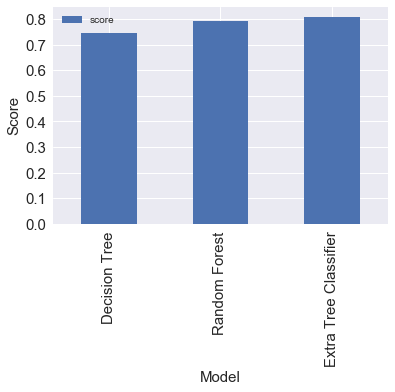

In [120]:
treeScore = treeEntropy.score(Xtest, Ytest)
forestScore = randomForest.score(Xtest, Ytest)
bagScore = bagTree.score(Xtest, Ytest)
pd.DataFrame([
    ("Decision Tree", treeScore),
    ("Random Forest", forestScore),
    ("Extra Tree Classifier", bagScore),
    ], columns=["Model", "score"]).plot(x="Model", y="score", kind="Bar", fontsize=15)
plt.xlabel('Model', fontsize=15)
plt.ylabel('Score', fontsize=15)

Forest and bag tree both score higher than decision tree, but only marginally so. We probably could improve our results through better imputation and features selection, though as of right now, an accuracy score of 80 is the maximum we could reach

## Cross Validating
Initiate cross validation to verify we did not overfit on the test set.

In [113]:
print cross_val_score(randomForest, X, Y, cv = 10)
print cross_val_score(bagTree, X, Y, cv = 10)

[ 0.80407339  0.80171688  0.80087527  0.80222185  0.81077441  0.79393939
  0.7983165   0.79440983  0.79525173  0.80447962]
[ 0.81939067  0.81770746  0.81686585  0.79835045  0.82070707  0.80774411
  0.81414141  0.80518606  0.80451254  0.82081509]


## Apply to test set

In [114]:
test = pd.read_csv('test_values.csv')

In [115]:
test = allcleaner(test)

/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [116]:
def bagPredictTest(test, method):
    test = allcleaner(test)
    removeAttr = [attr for attr in excludeAttr if attr!= 'status_group']
    prepTest = test.drop(removeAttr, axis = 1)
    testfactorConvert = [x for x in prepTest.columns if x not in numericAttr]
    for factor in testfactorConvert:
        prepTest[factor] = preprocessing.LabelEncoder().fit_transform(prepTest[factor])
    prediction = method.predict(prepTest)
    test['status_group'] = prediction
    test['status_group'] = test['status_group'].replace([0, 1, 2], ['functional', 'functional needs repair', 'non functional'])
    return test[['id', 'status_group']]

In [117]:
predict = bagPredictTest(test, bagTree)

/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


* Export results to csv

In [118]:
predict.to_csv('prediction.csv',index=False)